# 11 Exercise Architecture Comparison

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

# NLP librerie
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Scikit-learn
from sklearn.feature_extraction.text import (
    CountVectorizer, TfidfVectorizer
)
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
)

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.nn.utils.rnn import pad_sequence
from collections import Counter

# Download NLTK data
for resource in [
    'punkt', 'stopwords', 'wordnet',
    'punkt_tab', 'omw-1.4',
]:
    nltk.download(resource, quiet=True)

np.random.seed(42)
torch.manual_seed(42)

# Device configuration
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu'
)
print(f"Using device: {device}")
print("Setup completato")

import os, urllib.request, joblib

# GitHub Release URL for pretrained weights (update with actual URL)
WEIGHTS_BASE_URL = os.environ.get('WEIGHTS_URL', 'https://github.com/SamueleBolotta/CEAR/releases/download/v1.0/')
WEIGHTS_DIR = '../pretrained_weights'
os.makedirs(WEIGHTS_DIR, exist_ok=True)

def load_or_train(model, train_fn, weights_filename, device='cpu', tokenizer=None):
    """Load pretrained weights if available, otherwise train and save.
    If tokenizer is provided, its word_index is saved/loaded alongside the weights
    to ensure vocabulary consistency.
    Also saves/loads training history as JSON alongside weights."""
    weights_path = os.path.join(WEIGHTS_DIR, weights_filename)
    history_path = weights_path.replace('.pt', '_history.json')
    vocab_path = weights_path.replace('.pt', '_vocab.json')

    def _load_weights(path):
        model.load_state_dict(torch.load(path, map_location=device, weights_only=True))
        # Restore tokenizer vocabulary if saved alongside weights
        if tokenizer is not None and os.path.exists(vocab_path):
            import json as _json
            with open(vocab_path, 'r') as f:
                tokenizer.word_index = _json.load(f)
            print(f"  Restored tokenizer vocabulary ({len(tokenizer.word_index)} words)")

    def _load_history():
        if os.path.exists(history_path):
            import json as _json
            with open(history_path, 'r') as f:
                return _json.load(f)
        return None

    if os.path.exists(weights_path):
        _load_weights(weights_path)
        print(f"Loaded pretrained weights from {weights_path}")
        return _load_history()
    elif WEIGHTS_BASE_URL:
        try:
            url = WEIGHTS_BASE_URL + weights_filename
            urllib.request.urlretrieve(url, weights_path)
            # Also try downloading vocabulary
            if tokenizer is not None:
                try:
                    urllib.request.urlretrieve(
                        WEIGHTS_BASE_URL + weights_filename.replace('.pt', '_vocab.json'), vocab_path)
                except Exception:
                    pass
            # Also try downloading history
            try:
                urllib.request.urlretrieve(
                    WEIGHTS_BASE_URL + weights_filename.replace('.pt', '_history.json'), history_path)
            except Exception:
                pass
            _load_weights(weights_path)
            print(f"Downloaded and loaded weights from {url}")
            return _load_history()
        except Exception as e:
            print(f"Could not download weights: {e}. Training from scratch...")

    history = train_fn()
    torch.save(model.state_dict(), weights_path)
    print(f"Saved weights to {weights_path}")
    # Save history
    if history is not None:
        import json as _json
        with open(history_path, 'w') as f:
            _json.dump(history, f)
        print(f"Saved training history to {history_path}")
    # Save tokenizer vocabulary alongside weights
    if tokenizer is not None:
        import json as _json
        with open(vocab_path, 'w') as f:
            _json.dump(tokenizer.word_index, f)
        print(f"Saved tokenizer vocabulary to {vocab_path}")
    return history

Using device: cuda
Setup completato


In [3]:
# Caricamento dataset IMDB
from datasets import load_dataset

# Carica IMDB da Hugging Face datasets
imdb_dataset = load_dataset('imdb')

X_train_text = np.array(imdb_dataset['train']['text'])
y_train_imdb = np.array(imdb_dataset['train']['label'])
X_test_text = np.array(imdb_dataset['test']['text'])
y_test_imdb = np.array(imdb_dataset['test']['label'])

# Shuffle training e test set (il dataset HuggingFace
# e' ordinato per label, la versione Keras era shuffled)
rng = np.random.RandomState(42)
train_shuffle = rng.permutation(len(X_train_text))
X_train_text = X_train_text[train_shuffle]
y_train_imdb = y_train_imdb[train_shuffle]

test_shuffle = rng.permutation(len(X_test_text))
X_test_text = X_test_text[test_shuffle]
y_test_imdb = y_test_imdb[test_shuffle]

print(f"Training samples: {len(X_train_text)}")
print(f"Test samples: {len(X_test_text)}")

# Visualizza esempi
print("\nReview 1 (Positiva):")
pos_idx = np.where(y_train_imdb == 1)[0][0]
print(X_train_text[pos_idx][:500])
print(
    f"\nSentiment: "
    f"{'Positivo' if y_train_imdb[pos_idx] == 1 else 'Negativo'}"
)
print("\n" + "=" * 60 + "\n")

# Trova una review negativa
neg_idx = np.where(y_train_imdb == 0)[0][0]
print("Review 2 (Negativa):")
print(X_train_text[neg_idx][:500])
print(
    f"\nSentiment: "
    f"{'Positivo' if y_train_imdb[neg_idx] == 1 else 'Negativo'}"
)

print(f"\nDataset: {len(X_train_text)} train, "
      f"{len(X_test_text)} test")
print(f"Esempio: {X_train_text[0][:200]}...")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Training samples: 25000
Test samples: 25000

Review 1 (Positiva):
I dug out from my garage some old musicals and this is another one of my favorites. It was written by Jay Alan Lerner and directed by Vincent Minelli. It won two Academy Awards for Best Picture of 1951 and Best Screenplay. The story of an American painter in Paris who tries to make it big. Nina Foch is a sophisticated lady of means and is very interested in helping him, but soon finds she loves the guy. Meanwhile Gene Kelly falls for lovely damsel, Leslie Caron. His main dancing partner, and I m

Sentiment: Positivo


Review 2 (Negativa):
Dumb is as dumb does, in this thoroughly uninteresting, supposed black comedy. Essentially what starts out as Chris Klein trying to maintain a low profile, eventually morphs into an uninspired version of "The Three Amigos", only without any laughs. In order for black comedy to work, it must be outrageous, which "Play Dead" is not. In order for black comedy to work, it cannot be mean spi

In [ ]:
# Parametri Deep Learning
DL_VOCAB_SIZE = 10000
DL_MAX_LENGTH = 200
DL_EMBEDDING_DIM = 100

# Subset per Deep Learning
DL_N_TRAIN = 15000
DL_N_TEST = 2000


class SimpleTokenizer:
    """Tokenizer con preprocessing base per testi."""

    UNK_IDX = 1  # indice 0 = padding, indice 1 = unknown

    def __init__(self, num_words=10000):
        self.num_words = num_words
        self.word_index = {}

    @staticmethod
    def _clean(text):
        """Pulizia base: lowercase, rimuovi HTML, punteggiatura."""
        import re
        text = text.lower()
        text = re.sub(r'<[^>]+>', ' ', text)   # rimuovi tag HTML (<br /> etc.)
        text = re.sub(r'[^a-z\s]', ' ', text)  # solo lettere e spazi
        return text.split()

    def fit_on_texts(self, texts):
        counter = Counter()
        for text in texts:
            counter.update(self._clean(text))
        # Ordinamento stabile: per count decrescente, poi alfabetico
        sorted_words = sorted(
            counter.items(),
            key=lambda x: (-x[1], x[0])
        )[:self.num_words - 2]  # -2 per padding (0) e UNK (1)
        # Indice 0 = padding, indice 1 = UNK
        self.word_index = {
            word: i + 2
            for i, (word, _) in enumerate(sorted_words)
        }

    def texts_to_sequences(self, texts):
        return [
            [
                self.word_index.get(w, self.UNK_IDX)
                for w in self._clean(text)
            ]
            for text in texts
        ]


def pad_sequences_manual(sequences, maxlen, padding_value=0):
    """Padding manuale delle sequenze."""
    padded = []
    for seq in sequences:
        seq = seq[:maxlen]  # Truncate
        seq = seq + [padding_value] * (maxlen - len(seq))  # Pad
        padded.append(seq)
    return np.array(padded)


def make_test_loader(tokenizer, texts, labels, max_length, batch_size=64):
    """Create test DataLoader using current tokenizer vocabulary.
    This ensures test data is tokenized with the same vocabulary
    as the trained model (important when loading pretrained weights
    that may restore a different vocabulary)."""
    seqs = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences_manual(seqs, maxlen=max_length)
    X = torch.tensor(padded, dtype=torch.long)
    y = torch.tensor(labels.tolist() if hasattr(labels, 'tolist') else list(labels), dtype=torch.long)
    return DataLoader(TensorDataset(X, y), batch_size=batch_size)

In [ ]:
class LSTMClassifier(nn.Module):
    """Modello LSTM per sentiment analysis."""

    def __init__(
        self, vocab_size, embedding_dim, hidden_dim,
        output_dim=1, dropout=0.5,
    ):
        super().__init__()
        self.embedding = nn.Embedding(
            vocab_size, embedding_dim, padding_idx=0,
        )
        self.lstm = nn.LSTM(
            embedding_dim, hidden_dim, batch_first=True,
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        hidden = self.dropout(hidden[-1])
        return self.fc(hidden)


def train_model(
    model, train_loader, val_loader, epochs,
    lr=0.001, patience=2,


def evaluate_model(model, test_loader):
    """Valuta accuracy su test set."""
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            output = model(X_batch).squeeze(-1)
            predicted = (
                torch.sigmoid(output) > 0.5
            ).long()
            correct += (
                predicted == y_batch
            ).sum().item()
            total += y_batch.size(0)
    return correct / total


def make_loaders(
    X_train, y_train, X_test, y_test,
    batch_size=128, val_split=0.2,

## Esercizio 4

**Task**: Costruire e confrontare LSTM, Bidirectional LSTM
e GRU su review IMDB. Visualizzare training curves e
analizzare le differenze tra architetture.

Esercizio 4 - Train: (5000, 150)
Labels train: pos=2492, neg=2508
LSTM: 673,345 parametri
BiLSTM: 706,689 parametri
GRU: 665,025 parametri

TRAINING MODELLI

Training LSTM...
  Restored tokenizer vocabulary (9998 words)
Downloaded and loaded weights from https://github.com/SamueleBolotta/CEAR/releases/download/v1.0/nb07_ex4_lstm.pt
LSTM - Test: 0.6340, Epochs: 21

Training BiLSTM...
  Restored tokenizer vocabulary (9998 words)
Downloaded and loaded weights from https://github.com/SamueleBolotta/CEAR/releases/download/v1.0/nb07_ex4_bilstm.pt
BiLSTM - Test: 0.6810, Epochs: 16

Training GRU...
  Restored tokenizer vocabulary (9998 words)
Downloaded and loaded weights from https://github.com/SamueleBolotta/CEAR/releases/download/v1.0/nb07_ex4_gru.pt
GRU - Test: 0.6680, Epochs: 23

RISULTATI FINALI
 model  train_acc  test_acc best_val_loss  epochs
BiLSTM     0.6880     0.681        0.6025      16
   GRU     0.6686     0.668        0.6435      23
  LSTM     0.6500     0.634        0.6338    

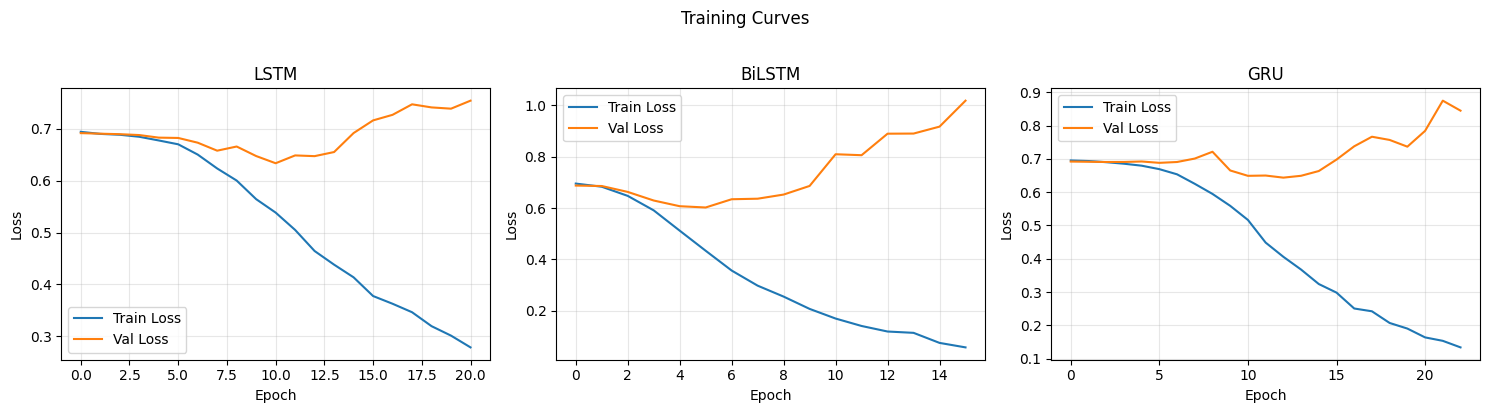


CONFRONTO DL vs ML CLASSICO (tutorial)
Logistic Regression (TF-IDF): 0.8610
LSTM                     : 0.6340
BiLSTM                   : 0.6810
GRU                      : 0.6680

Esercizio 4 completato


In [18]:
# =========================================================
# ESERCIZIO 4: Confronto Architetture Deep Learning
# =========================================================

# Subset dedicato (diverso dal tutorial)
ex4_n_train = 5000
ex4_n_test = 1000

# Usiamo la seconda meta' del training set per evitare
# overlap col tutorial (che usa [:DL_N_TRAIN] = [:15000])
ex4_start = 15000
ex4_X_train_text = X_train_text[
    ex4_start:ex4_start + ex4_n_train
]
ex4_y_train = y_train_imdb[
    ex4_start:ex4_start + ex4_n_train
]
ex4_X_test_text = X_test_text[:ex4_n_test]
ex4_y_test = y_test_imdb[:ex4_n_test]

# Tokenizzazione dedicata
ex4_vocab_size = 10000
ex4_max_length = 150
ex4_embedding_dim = 64

ex4_tokenizer = SimpleTokenizer(
    num_words=ex4_vocab_size,
)
ex4_tokenizer.fit_on_texts(ex4_X_train_text)

# Tokenize SOLO training data (test dopo load_or_train)
ex4_X_train = pad_sequences_manual(
    ex4_tokenizer.texts_to_sequences(ex4_X_train_text),
    maxlen=ex4_max_length,
)

print(f"Esercizio 4 - Train: {ex4_X_train.shape}")
print(f"Labels train: pos={sum(ex4_y_train==1)}, "
      f"neg={sum(ex4_y_train==0)}")


# Step 1: Definizione architetture
class Ex4LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(
            ex4_vocab_size, ex4_embedding_dim,
            padding_idx=0,
        )
        self.lstm = nn.LSTM(
            ex4_embedding_dim, 64, batch_first=True,
        )
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        raise NotImplementedError()


class Ex4BiLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(
            ex4_vocab_size, ex4_embedding_dim,
            padding_idx=0,
        )
        self.lstm = nn.LSTM(
            ex4_embedding_dim, 64,
            batch_first=True, bidirectional=True,
        )
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        raise NotImplementedError()
        return self.fc(self.dropout(hidden))


class Ex4GRU(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(
            ex4_vocab_size, ex4_embedding_dim,
            padding_idx=0,
        )
        self.gru = nn.GRU(
            ex4_embedding_dim, 64, batch_first=True,
        )
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        embedded = self.embedding(x)
        raise NotImplementedError()
        return self.fc(self.dropout(hidden[-1]))


ex4_models = {
    'LSTM': Ex4LSTM().to(device),
    'BiLSTM': Ex4BiLSTM().to(device),
    'GRU': Ex4GRU().to(device),
}

for name, model in ex4_models.items():
    n_p = sum(p.numel() for p in model.parameters())
    print(f"{name}: {n_p:,} parametri")

# Tokenize test con vocabolario iniziale (sara' ri-tokenizzato dopo load_or_train)
ex4_X_test_initial = pad_sequences_manual(
    ex4_tokenizer.texts_to_sequences(ex4_X_test_text),
    maxlen=ex4_max_length,
)

# DataLoaders per esercizio 4
ex4_train_loader, ex4_val_loader, ex4_test_loader = \
    make_loaders(
        ex4_X_train, ex4_y_train,
        ex4_X_test_initial, ex4_y_test,
        batch_size=64,
    )

# Step 2: Training (with pretrained weight support)
ex4_histories = {}
ex4_results = []

ex4_weight_names = {
    'LSTM': 'nb07_ex4_lstm.pt',
    'BiLSTM': 'nb07_ex4_bilstm.pt',
    'GRU': 'nb07_ex4_gru.pt',
}

print("\n" + "=" * 60)
print("TRAINING MODELLI")
print("=" * 60)

for name, model in ex4_models.items():
    print(f"\nTraining {name}...")

    history = load_or_train(
        model,
        lambda m=model: train_model(
            m, ex4_train_loader, ex4_val_loader,
            epochs=15, patience=5,
        ),
        ex4_weight_names[name],
        device=device, tokenizer=ex4_tokenizer,
    )
    ex4_histories[name] = history

    # Re-tokenize test data with (possibly restored) vocabulary
    ex4_test_loader = make_test_loader(
        ex4_tokenizer, ex4_X_test_text, ex4_y_test,
        ex4_max_length, batch_size=64,
    )

    # Re-tokenize train data with (possibly restored) vocabulary
    ex4_train_loader = make_test_loader(
        ex4_tokenizer, ex4_X_train_text, ex4_y_train,
        ex4_max_length, batch_size=64,
    )

    test_acc = evaluate_model(
        model, ex4_test_loader,
    )
    train_acc = evaluate_model(
        model, ex4_train_loader,
    )

    n_epochs = len(history['loss']) if history is not None else "N/A"
    best_val_loss = min(history['val_loss']) if history is not None else "N/A"
    ex4_results.append({
        'model': name,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'best_val_loss': best_val_loss if isinstance(best_val_loss, str) else f"{best_val_loss:.4f}",
        'epochs': n_epochs,
    })

    print(
        f"{name} - Test: {test_acc:.4f}, "
        f"Epochs: {n_epochs}"
    )

# Step 3: Risultati
ex4_results_df = pd.DataFrame(ex4_results).sort_values(
    'test_acc', ascending=False,
)

print("\n" + "=" * 60)
print("RISULTATI FINALI")
print("=" * 60)
print(ex4_results_df.to_string(index=False))

# Step 4: Training curves
if any(h is not None for h in ex4_histories.values()):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    for idx, (name, hist) in enumerate(
        ex4_histories.items()
    ):
        ax = axes[idx]
        if hist is not None:
            ax.plot(hist['loss'], label='Train Loss')
            ax.plot(hist['val_loss'], label='Val Loss')
        else:
            ax.text(0.5, 0.5, 'Pretrained\n(no curves)',
                    ha='center', va='center',
                    transform=ax.transAxes, fontsize=12)
        ax.set_title(name)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()
        ax.grid(alpha=0.3)

    plt.suptitle('Training Curves', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("Using pretrained weights - training curves not available")

# Step 5: Confronto con approccio classico
print("\n" + "=" * 60)
print("CONFRONTO DL vs ML CLASSICO (tutorial)")
print("=" * 60)
print(f"Logistic Regression (TF-IDF): {acc_lr:.4f}")
for r in ex4_results:
    print(f"{r['model']:25s}: {r['test_acc']:.4f}")

print("\nEsercizio 4 completato")